In [34]:
## load packages 
import pandas as pd
import re
import numpy as np

## nltk imports
#!pip install nltk # can install on terminal or by uncommenting this line
#import nltk; nltk.download('punkt'); nltk.download('stopwords')
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import matplotlib.pyplot as plt

## sklearn imports
from sklearn.feature_extraction.text import CountVectorizer

## lda
#!pip install gensim # can install by uncommenting this line
from gensim import corpora
import gensim

## sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## visualizing LDA--likely need to install
#!pip install pyLDAvis # can install by uncommenting this line
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
pyLDAvis.enable_notebook()

## print mult things
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## random
import random
import string; punctlist = [char for char in string.punctuation] # list of english punctuation marks

In [35]:
import spacy
sp = spacy.load('en_core_web_sm')
import en_core_web_sm
nlp = en_core_web_sm.load()
import ast

## Load Data

In [36]:
estee_df = pd.read_csv("/Users/giselle/Desktop/Dartmouth/Skinfluence/data/instagram_estee.csv")
estee_df.head()

,content_type,creation_time,hashtags,id,is_branded_content,lang,match_type,mcl_url,modified_time,multimedia,post_owner.type,post_owner.id,post_owner.name,post_owner.username,statistics.comment_count,statistics.like_count,statistics.views,statistics.views_date_last_refreshed,text
0,albums,2025-05-29T13:40:32+00:00,NaN,9037049469730638,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-05-29T14:09:23+00:00,"[{""id"":""1195280392333492"",""type"":""photo"",""url""...",business,697049243083530,NykaaLuxe,nykaaluxe,0.0,5.0,NaN,NaN,Every makeup look starts with the right founda...
1,videos,2025-05-29T11:00:00+00:00,"[""esteelauder"",""esteelauderph""]",677638275152084,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-05-29T11:42:48+00:00,"[{""id"":""677638275152084"",""type"":""video"",""durat...",business,1253268905916813,Estée Lauder Philippines Market,esteelauderph,0.0,9.0,258.0,2025-05-29,"Rose-tinted beauty, made to flatter every look..."
2,videos,2025-05-29T10:11:30+00:00,NaN,664046526456955,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-05-29T11:16:00+00:00,"[{""id"":""664046526456955"",""type"":""video"",""durat...",business,1923579061413269,ION Orchard,ion_orchard,0.0,6.0,558.0,2025-05-29,A Day Like No Other is coming on 6 June! Enjoy...
3,albums,2025-05-28T13:00:25+00:00,"[""palmbeach"",""modernluxuryinteriors"",""modernlu...",2187097268387284,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-05-28T13:11:41+00:00,"[{""id"":""1215820702879124"",""type"":""photo"",""url""...",business,432005872700097,Modern Luxury,modernluxury,66.0,3217.0,58152.0,2025-05-29,Aerin Lauder cultivates an elegant legacy in f...
4,videos,2025-05-28T11:00:00+00:00,"[""est\u00e9eessentials"",""esteelauder"",""esteela...",1230348168650378,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-05-29T00:10:07+00:00,"[{""id"":""1230348168650378"",""type"":""video"",""dura...",business,1253268905916813,Estée Lauder Philippines Market,esteelauderph,1.0,17.0,828.0,2025-05-29,Beauty that moves with ease — through coffee r...


In [37]:
custom_words_toad = [
    'estee', 'lauder', 'esteelauder', 'esteelaudersg', 'advancednightrepair', 'anr',  
    'video', 'youtube', 'tiktok', 'instagram', 'reel', 'feed',                        
    'like', 'likes', 'comment', 'comments', 'share', 'save', 'follow', 'subscribe',  
    'today', 'now', 'new', 'shop', 'buy', 'link', 'bio', 'visit', 'available',       
    'beauty', 'skin', 'skincare', 'routine', 'makeup', 'product', 'products',       
    '✨', '🔥', '💧', '💫', '😍', '💖',                                                
    'feel', 'love', 'use', 'try', 'amazing', 'favorite', 'best',                     
    'night', 'repair', 'serum', 'hydrating', 'hydration', 'cream',                    
    'hey', 'hello', 'welcome', 'thank', 'you', 'everyone', 'guys'                    
]


def preprocess(df_col, custom_words_toad):
    porter = PorterStemmer()
    list_stopwords = stopwords.words("english")
    new_stopwords = set(list_stopwords + custom_words_toad)

    corpus_lower = df_col.fillna("").str.lower().to_list()

    nostop_listing = []
    for text in corpus_lower:
        # Clean URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Tokenize and remove stopwords
        tokens = [
            word for word in wordpunct_tokenize(text)
            if word.isalpha() and word not in new_stopwords
        ]
        # Apply stemming
        stemmed_tokens = [porter.stem(word) for word in tokens if len(word) > 2]
        nostop_listing.append(stemmed_tokens)

    return nostop_listing
    
estee_df["text_clean"] = preprocess(estee_df["text"], custom_words_toad)

In [38]:
## function provided
def create_dtm(list_of_strings, metadata):
    """ 
    Function to create dense document-term matrix (DTM) from a list of strings and provided metadata. 
    A sparse DTM is a list of term_index/doc_index tuples: if a given term occurs in a given doc at least once, 
        then this count is listed as a tuple; if not, that term/doc pair is omitted. 
    In a dense DTM, each row is one text (e.g., an Airbnb listing), each column is a term, and 
        each cell indicates the frequency of that word in that text. 
    
    Parameters:
        list_of_strings (Series): each row contains a preprocessed string (need not be tokenized)
        metadata (DataFrame): contains document-level covariates
    
    Returns:
        Dense DTM with metadata on left and then one column per word in lexicon
    """
    
    # initialize a sklearn tokenizer; this helps us tokenize the preprocessed string input
    vectorizer = CountVectorizer(lowercase = True) 
    dtm_sparse = vectorizer.fit_transform(list_of_strings)
    print('Sparse matrix form:\n', dtm_sparse[:3]) # take a look at sparse representation
    print()
    
    # switch the dataframe from the sparse representation to the normal dense representation (so we can treat it as regular dataframe)
    dtm_dense_named = pd.DataFrame(dtm_sparse.todense(), columns=vectorizer.get_feature_names_out ())
    print('Dense matrix form:\n', dtm_dense_named.head()) # take a look at dense representation
    dtm_dense_named_withid = pd.concat([metadata.reset_index(drop=True), dtm_dense_named], axis = 1) # add back document-level covariates

    return(dtm_dense_named_withid)

In [39]:
## process text more, lower and to string
estee_df["text_clean_str"] = estee_df["text_clean"].apply(lambda tokens: " ".join(tokens).lower())

### NLP

In [40]:
# Define function to extract GPEs from one string
def get_org(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ == "ORG"]


In [41]:
# Define function to extract product from one string
def get_product(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ == "PRODUCT"]


In [51]:
# Apply it to the Instagram dataset
estee_df["org_entities"] = estee_df["text_clean_str"].apply(get_org)

# Optional: see sample output
estee_df[["text_clean_str", "org_entities"]].head()

,text_clean_str,gpe_entities
creation_time,,
2025-05-29 13:40:32+00:00,everi look start right foundat readi find swip...,[ysl]
2025-05-29 11:00:00+00:00,rose tint made flatter everi look whether go s...,[]
2025-05-29 10:11:30+00:00,day come june enjoy special partner rebat boos...,"[louboutin, atico picota]"
2025-05-28 13:00:25+00:00,aerin cultiv eleg legaci full bloom freshli re...,[photographi brantleyphoto]
2025-05-28 11:00:00+00:00,move eas coffe run quiet moment everyth effort...,[]


In [53]:
# Apply it to the Instagram dataset
estee_df["product_entities"] = estee_df["text_clean_str"].apply(get_product)
estee_df[["text_clean_str", "product_entities"]].head()

KeyboardInterrupt: 

### Sentiment Analysis

In [42]:
## initialize a scorer
sent_obj = SentimentIntensityAnalyzer()
print(type(sent_obj))
## score one listing
practice_listing = "NICE AND COZY LITTLE APT AVAILABLE"
sentiment_example = sent_obj.polarity_scores(practice_listing)
sentiment_example

<class 'vaderSentiment.vaderSentiment.SentimentIntensityAnalyzer'>


{'neg': 0.0, 'neu': 0.641, 'pos': 0.359, 'compound': 0.4215}

In [43]:
estee_df["sentiment"] = estee_df["text_clean_str"].apply(sent_obj.polarity_scores)

In [44]:
estee_df["compound"] = estee_df["sentiment"].apply(lambda x: x["compound"])

<Axes: xlabel='statistics.views', ylabel='compound'>

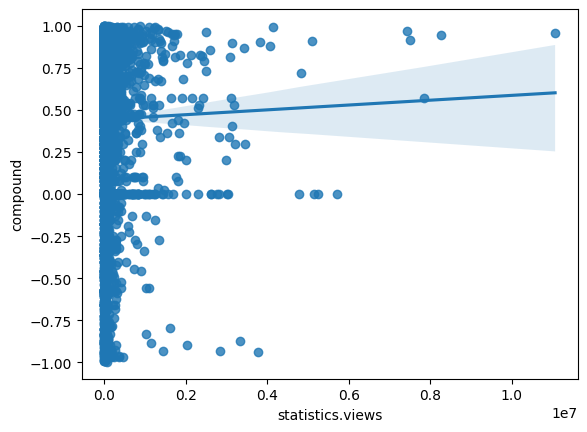

In [45]:
import seaborn as sns
sns.regplot(x = estee_df["statistics.views"], y = estee_df.compound)

This scatterplot shows the relationship between:
- **x-axis**: statistics.views, which is the number of views an Instagram post got
- **y-axis**: compound, which is the sentiment score from VADER (+1 = very positive, -1 = very negative)

As we can see, most of the estee lauder posts have a view count of under 2 millions views, with most posts having a **positive sentiment**. The regression line is slightly rising, meaning posts with more views tend to have slightly more positive sentiment, but the effect is very small.



### Sentiment Analysis for Branded vs Nonbraded

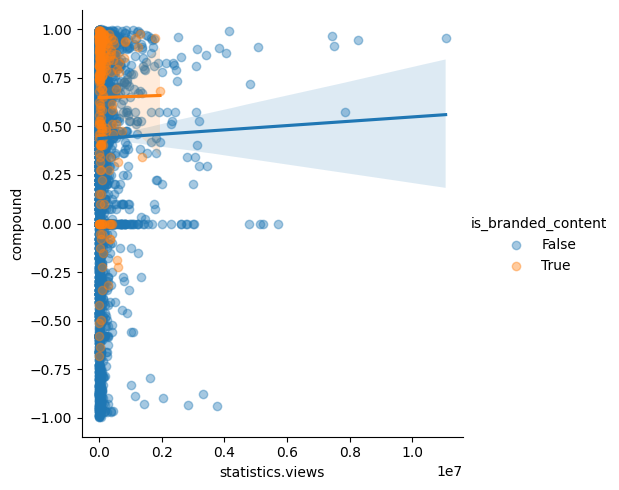

In [46]:
## Comparing Branded and NonBranded Sentiment
sns.lmplot(data=estee_df, x="statistics.views", y="compound", hue="is_branded_content", scatter_kws={"alpha": 0.4})

In [47]:
is_brand_num = len(estee_df[estee_df["is_branded_content"] == True])
is_brand_num
nonbrand_num = len(estee_df[estee_df["is_branded_content"] == False])
nonbrand_num

401

16988

#### Observations
The plot shows a clear imbalance in the dataset: there are far more non-branded posts than branded ones (16,988 vs. 401). Most branded posts cluster around high sentiment scores, especially between 0.75 and 1.0, indicating strong positive sentiment. This aligns with expectations—branded content tends to use more promotional and upbeat language.

In contrast, non-branded content spans a broader sentiment range, including both highly positive and negative values, suggesting more varied and authentic user expression.

Interestingly, while branded content is consistently positive, it doesn’t appear to drive significantly higher view counts—both branded and non-branded posts are heavily concentrated under 1 million views. The weak slope of the regression line also indicates that sentiment is not a strong predictor of view count. This suggests that while branded posts may aim to maintain positivity, it’s not necessarily sentiment that drives engagement or visibility. Overall, branded content appears polished and emotionally safe, whereas non-branded content provides richer insights into public perception, making it valuable for understanding audience sentiment in a more nuanced way.

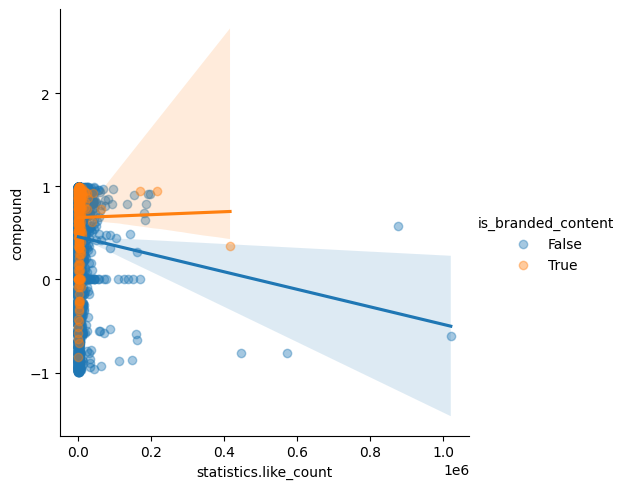

In [19]:
## Comparing Branded and NonBranded Sentiment and like count
sns.lmplot(data=estee_df, x="statistics.like_count", y="compound", hue="is_branded_content", scatter_kws={"alpha": 0.4})

From the plot, we can see a distinct difference in how sentiment relates to like counts for branded and non-branded content.

- **Branded posts (orange)** tend to cluster in the **positive** sentiment range, especially between compound scores of 0.5 to 1.0. The slight **upward** trend suggests that more liked branded content tends to be more positive — though the sample size may be small.

- **Non-branded posts (blue)** show a wider spread of sentiment, ranging from very negative to very positive. Interestingly, there's a **slight negative** trend: more liked non-branded posts actually correlate with slightly lower sentiment. This might reflect how critical or edgy posts can still attract engagement. That said, this trend might be misleading --- there is only one non-branded post with an unusually high like count and low sentiment, which could skew the regression line. Most content overall stays within a lower like range regardless of tone.

The concentration near the origin (low like counts) for both categories suggests that most posts don't go viral — and sentiment doesn't strongly predict popularity in the general case.



### Hashtags and Sentiment

In [48]:
## convert to list 
estee_df['hashtags'] = estee_df['hashtags'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith("[") else x
)
hashtag_df = estee_df.explode("hashtags")

In [49]:
hashtag_df.head()

,content_type,creation_time,hashtags,id,is_branded_content,lang,match_type,mcl_url,modified_time,multimedia,...,post_owner.username,statistics.comment_count,statistics.like_count,statistics.views,statistics.views_date_last_refreshed,text,text_clean,text_clean_str,sentiment,compound
0,albums,2025-05-29T13:40:32+00:00,NaN,9037049469730638,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-05-29T14:09:23+00:00,"[{""id"":""1195280392333492"",""type"":""photo"",""url""...",...,nykaaluxe,0.0,5.0,NaN,NaN,Every makeup look starts with the right founda...,"[everi, look, start, right, foundat, readi, fi...",everi look start right foundat readi find swip...,"{'neg': 0.0, 'neu': 0.856, 'pos': 0.144, 'comp...",0.5719
1,videos,2025-05-29T11:00:00+00:00,esteelauder,677638275152084,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-05-29T11:42:48+00:00,"[{""id"":""677638275152084"",""type"":""video"",""durat...",...,esteelauderph,0.0,9.0,258.0,2025-05-29,"Rose-tinted beauty, made to flatter every look...","[rose, tint, made, flatter, everi, look, wheth...",rose tint made flatter everi look whether go s...,"{'neg': 0.06, 'neu': 0.68, 'pos': 0.26, 'compo...",0.6124
1,videos,2025-05-29T11:00:00+00:00,esteelauderph,677638275152084,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-05-29T11:42:48+00:00,"[{""id"":""677638275152084"",""type"":""video"",""durat...",...,esteelauderph,0.0,9.0,258.0,2025-05-29,"Rose-tinted beauty, made to flatter every look...","[rose, tint, made, flatter, everi, look, wheth...",rose tint made flatter everi look whether go s...,"{'neg': 0.06, 'neu': 0.68, 'pos': 0.26, 'compo...",0.6124
2,videos,2025-05-29T10:11:30+00:00,NaN,664046526456955,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-05-29T11:16:00+00:00,"[{""id"":""664046526456955"",""type"":""video"",""durat...",...,ion_orchard,0.0,6.0,558.0,2025-05-29,A Day Like No Other is coming on 6 June! Enjoy...,"[day, come, june, enjoy, special, partner, reb...",day come june enjoy special partner rebat boos...,"{'neg': 0.033, 'neu': 0.826, 'pos': 0.141, 'co...",0.8910
3,albums,2025-05-28T13:00:25+00:00,palmbeach,2187097268387284,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-05-28T13:11:41+00:00,"[{""id"":""1215820702879124"",""type"":""photo"",""url""...",...,modernluxury,66.0,3217.0,58152.0,2025-05-29,Aerin Lauder cultivates an elegant legacy in f...,"[aerin, cultiv, eleg, legaci, full, bloom, fre...",aerin cultiv eleg legaci full bloom freshli re...,"{'neg': 0.0, 'neu': 0.973, 'pos': 0.027, 'comp...",0.2023


In [50]:
hashtag_sentiment = (
    hashtag_df.groupby("hashtags")["compound"]
    .mean()
    .sort_values(ascending=False)
)

In [51]:
hashtag_stats = (
    hashtag_df.groupby("hashtags")
    .agg(avg_sentiment=("compound", "mean"), count=("compound", "count"))
    .sort_values(by="avg_sentiment", ascending=False)
)

In [52]:
filtered = hashtag_stats[hashtag_stats["count"] >= 10]

<Figure size 1000x500 with 0 Axes>

<Axes: title={'center': 'Top Hashtags by Avg Sentiment'}, ylabel='hashtags'>

Text(0.5, 0, 'Avg Compound Sentiment')

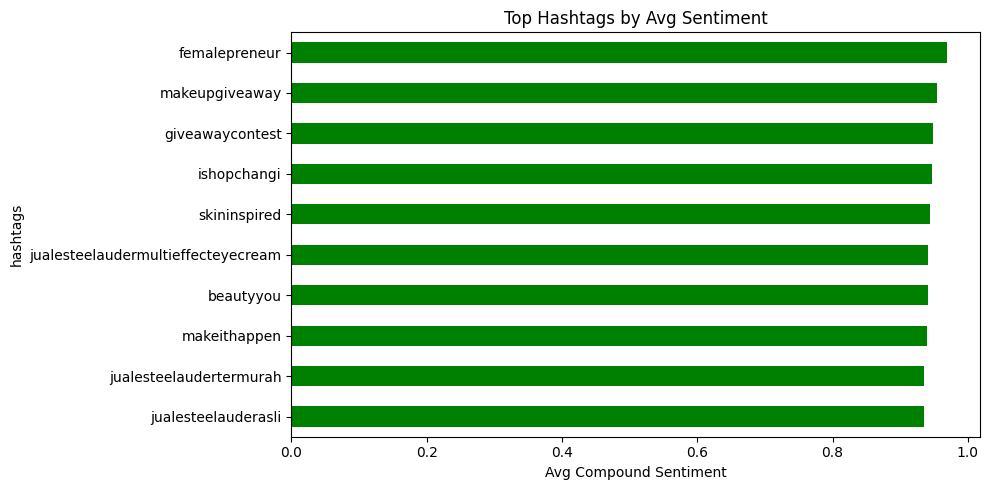

<Figure size 1000x500 with 0 Axes>

<Axes: title={'center': 'Lowest Sentiment Hashtags'}, ylabel='hashtags'>

Text(0.5, 0, 'Avg Compound Sentiment')

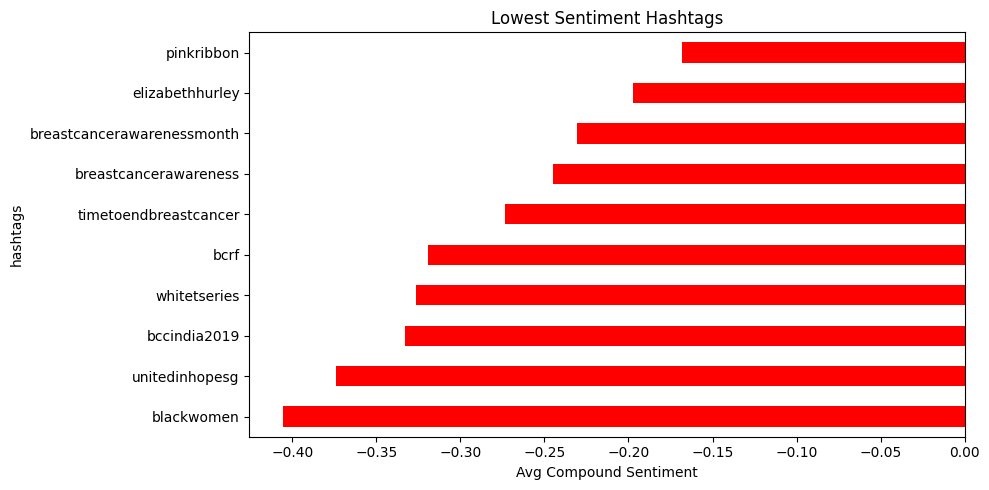

In [53]:
top10 = filtered.head(10)
bottom10 = filtered.tail(10)

plt.figure(figsize=(10, 5))
top10["avg_sentiment"].plot(kind="barh", color="green", title="Top Hashtags by Avg Sentiment")
plt.xlabel("Avg Compound Sentiment")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
bottom10["avg_sentiment"].plot(kind="barh", color="red", title="Lowest Sentiment Hashtags")
plt.xlabel("Avg Compound Sentiment")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Hashtag Sentiment Analysis Interpretation
#### Top Hashtags by Sentiment Analysis
Based on the two graphs, the hashtags with the highest average sentiment include **#femalepreneur, #makeupgiveaway, and #multieffecteyecream**, indicating strong positive reactions from users. This suggests that Estée Lauder’s campaigns promoting **women’s empowerment, product giveaways, and skincare lines** are resonating well with audiences. Additionally, high sentiment associated with hashtags in*Bahasa Indonesia or Malay (e.g., #jualesteelaudertermurah) indicates that Estée Lauder enjoys positive brand perception in **Southeast Asian** markets, especially in the context of affordability and accessibility. Overall, the consistently positive sentiment across these hashtags suggests that the brand’s marketing efforts are both emotionally resonant and internationally effective.

#### Lowest Hashtags by Sentiment Analysis
The graph displays the hashtags with the lowest average sentiment scores, with terms like **#breastcancerawarenessmonth, #timetoeendbreastcancer, and #pinkribbon** appearing prominently. These hashtags are closely tied to Breast Cancer Awareness campaigns, yet their low sentiment scores likely reflect a **limitation** of the sentiment analysis tool rather than genuine negativity. Models like VADER rely on individual word polarity, so emotionally heavy terms such as "cancer," "diagnosed," or "survivor" can skew the sentiment negatively, even when the overall message is **hopeful, supportive, or awareness-driven**. For example, a post honoring a survivor or discussing the impact of breast cancer may contain compassionate intent but still be flagged as negative due to language associated with illness or loss. You can see the text and their compound rating below. Additionally, hashtags like #blackwomen may be part of broader conversations about health equity or underrepresentation, which can surface complex or critical discourse not easily captured by standard sentiment tools. These results highlight the importance of considering context and social intent when interpreting sentiment scores, especially in campaigns related to health, advocacy, and inclusion.

In reality, these posts are often tied to deeply meaningful, supportive messaging. Their frequency in the dataset actually points to Estée Lauder’s **strong commitment to breast cancer advocacy**, showing that the brand continues to spotlight this cause prominently across their content.

To better reflect the true tone of such socially driven campaigns, a more **nuanced** analysis would be needed—such as applying context-aware models (like transformer-based sentiment classifiers), adding a custom label for awareness content, or even conducting qualitative keyword and theme analysis rather than relying solely on sentiment scores. This would avoid misinterpreting emotionally sensitive but impactful content and give a more accurate picture of Estée Lauder’s brand voice and values.

In [63]:
bc_df = estee_df[estee_df['hashtags'].astype(str).str.contains("breastcancer", case=False, na=False)]
text_compound = bc_df[["text", "compound", "sentiment"]]
pd.set_option('display.max_colwidth', None)
text_compound.sample(10)  # 10 random rows

,text,compound,sentiment
14276,"Thank you @modamalaysia for including me in this very meaningful cause for #Pinktober 💝Thank you to all sponsors @bravoeventz & partners <redacted_mention> @ddddaaauus @fsstudios_ <redacted_mention> who believed in us to make this Pink project a great success! Many thanks @melindalooi @custom.miked @therealbellarahim <redacted_mention> <redacted_mention> & all commitee members & volunteers for working tirelessly to make it a reality! Thank you heaps to W Kuala Lumpur Hotel for having us all at your uber cool place! Grateful thanks to Estée Lauder, <redacted_mention> <redacted_mention> & @mikogalere & team for making our breast cancer survivors looking fab & confident! Dr Farah <redacted_mention>, thank you so much for making time to be there to do health checks. All 16 pairs of Pink Buddies, it was truly inspirational & life changing listening to each of your stories! Thank you so much for joining & sharing your unique experiences with us...Please continue to stay strong & well 💓💓Media friends and fellow designers, so happy to see everyone, always great working together & thank you all for your support & love always! 💕 Keep well and stay safe everyone 💖 Next up...Pink Parade on 10/10/2020 💞💞💞#modaforbreastcancerawareness #modadesignercares #celestcares #celestthoientourage #celestthoi #supportlocal #localdesigners #moda #breastcancerawareness #pinktober2020 #blessed #thankyou",0.9906,"{'neg': 0.032, 'neu': 0.614, 'pos': 0.354, 'compound': 0.9906}"
2186,"30 years ago, Evelyn H. Lauder co-created the iconic Pink Ribbon, the international symbol of breast cancer today. That same year, she founded The Estée Lauder Companies Breast Cancer Campaign, which works to fund life-saving research, education, and medical services. \n-\n\nIl y a 30 ans, Evelyn H. Lauder a co-créé le Ruban Rose et lancé la Campagne contre le cancer du sein du groupe Estée Lauder Companies. Elle soutient la recherche, l’éducation et les services médicaux dans le monde entier. \n\n#TimeToEndBreastCancer #Darphin #PinkOctober #RubanRose",-0.9001,"{'neg': 0.202, 'neu': 0.749, 'pos': 0.049, 'compound': -0.9001}"
16417,"In support of Estée Lauder Companies’ Breast Cancer campaign, @lamermy will be doing their part in this campaign. Made in support of this campaign, hydrate with a purpose with a limited-edition, travel-size Treatment Lotion. It is exclusively available at La Mer retail stores in Suria KLCC and Gurney Plaza, Penang. For each purchase made from now, 20% of proceeds will donated to selected breast cancer beneficiaries in Malaysia. #TimeToEndBreastCancer #LaMerMy #GiftedbyLamer",-0.6597,"{'neg': 0.172, 'neu': 0.723, 'pos': 0.105, 'compound': -0.6597}"
8598,"Join our Pink Merlion Creative Family Photo Contest and stand to win attractive prizes!\n\nFrom 16 October to 13 November, our national icon, the Merlion, will glow in PINK in commemoration of Breast Cancer Awareness Month 2022. Snap a photo with your family with the PINK Merlion and take part in our unique photo contest.\n\nContest Requirements:\n\nStep 1:\nFollow Instagram accounts @bcfsg & @esteelauder_sg\n\nStep 2:\n(a) Snap your most creative photo of the Pink Merlion.\n(b) Photo must contain 1 or more family members with the Pink Merlion.\n(c) Post them on your Instagram within the stipulated contest period (16 October 2022 – 13 November 2022, 2359hrs). Use the following hashtags on the post.:\n\n#PinkMerlionCreativeFamilyPhoto2022\n\nStep 3:\nTag the following 2 Instagram accounts in your submission:\n1. @bcfsg\n2. @Esteelauder_sg\n\nEach submission should be a single image without alteration. No photo collages are allowed.\n\nStep 4:\nMake sure your Instagram profile is set as a public profile for the entire duration of the competition and through the exhibition period (until 31 Dec 2022).\n\na) The Contest will run from 16 October 2022 to 13 November 2022, 2359hrs. Judging will take place from 14 November 2022 to 26 November 2022 and winners will be notified 

## LDA

In [19]:
## example application on raw lowercase texts; 
dtm_nopre = create_dtm(list_of_strings= estee_df.text_clean_str,
                      metadata = estee_df[['is_branded_content', 'hashtags', 'post_owner.name']])

Sparse matrix form:
   (0, 13773)	1
  (0, 24890)	1
  (0, 40158)	1
  (0, 36015)	1
  (0, 15601)	2
  (0, 35117)	1
  (0, 14955)	1
  (0, 41299)	1
  (0, 11069)	1
  (0, 32572)	1
  (0, 26931)	1
  (0, 30759)	1
  (0, 30741)	2
  (0, 25311)	1
  (0, 33898)	1
  (0, 25344)	1
  (0, 29395)	1
  (0, 13570)	1
  (0, 14757)	1
  (0, 19511)	1
  (0, 47378)	1
  (1, 13773)	1
  (1, 24890)	2
  (1, 32572)	1
  (1, 13570)	2
  :	:
  (2, 44895)	1
  (2, 3208)	1
  (2, 5041)	1
  (2, 46783)	1
  (2, 7951)	1
  (2, 12156)	1
  (2, 13073)	1
  (2, 17886)	1
  (2, 23289)	1
  (2, 36100)	1
  (2, 37691)	1
  (2, 21635)	1
  (2, 40831)	1
  (2, 45056)	1
  (2, 37472)	1
  (2, 33063)	1
  (2, 5532)	1
  (2, 6326)	1
  (2, 7284)	1
  (2, 22481)	1
  (2, 9576)	1
  (2, 9337)	1
  (2, 46418)	1
  (2, 14901)	1
  (2, 23276)	1

Dense matrix form:
    aaaaaall  aaaaallott  aaaag  aaaand  aaah  aaccept  aadrika  aadrikasomind  \
0         0           0      0       0     0        0        0              0   
1         0           0      0       0     0    

In [20]:
## show first set of rows/cols
dtm_nopre.head()

## show arbitrary later cols in resulting data
dtm_nopre.shape
dtm_nopre.iloc[0:5, 480:500]

,is_branded_content,hashtags,post_owner.name,aaaaaall,aaaaallott,aaaag,aaaand,aaah,aaccept,aadrika,...,𝚋𝚎𝚊𝚞𝚝𝚢,𝚋𝚛𝚎𝚎𝚍𝚜,𝚍𝚊𝚒𝚕𝚢,𝚍𝚛𝚎𝚊𝚖𝚎𝚍,𝚏𝚘𝚛,𝚖𝚘𝚛𝚎,𝚗𝚎𝚟𝚎𝚛,𝚘𝚠𝚗𝚎𝚍,𝚜𝚞𝚌𝚌𝚎𝚜𝚜,𝚠𝚘𝚛𝚔𝚎𝚍
0,False,NaN,NykaaLuxe,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,False,"[""esteelauder"",""esteelauderph""]",Estée Lauder Philippines Market,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,False,NaN,ION Orchard,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,False,"[""palmbeach"",""modernluxuryinteriors"",""modernlu...",Modern Luxury,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,False,"[""est\u00e9eessentials"",""esteelauder"",""esteela...",Estée Lauder Philippines Market,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(17389, 51666)

,advic,adviesprij,advis,adviseert,advisit,advisor,advisori,advnacedstyleolderandwis,advncednightrepair,advoc,advocaci,adweek,adwoaaboah,adwoabeauti,adya,aedt,aegea,aemilia,aeon,aequo
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
top_terms = dtm_nopre[dtm_nopre.columns[4:]].sum(axis = 0)

## sorting from most frequent to least frequent
top_terms.sort_values(ascending = False)

esté               19099
foundat             4920
brand               3916
look                3899
wear                3751
                   ...  
kidswear               1
kidston                1
kidsofinstagram        1
kidsofig               1
𝚠𝚘𝚛𝚔𝚎𝚍                 1
Length: 51662, dtype: int64

In [22]:
print(dtm_nopre.columns)


Index(['is_branded_content', 'hashtags', 'post_owner.name', 'aaaaaall',
       'aaaaallott', 'aaaag', 'aaaand', 'aaah', 'aaccept', 'aadrika',
       ...
       '𝚋𝚎𝚊𝚞𝚝𝚢', '𝚋𝚛𝚎𝚎𝚍𝚜', '𝚍𝚊𝚒𝚕𝚢', '𝚍𝚛𝚎𝚊𝚖𝚎𝚍', '𝚏𝚘𝚛', '𝚖𝚘𝚛𝚎', '𝚗𝚎𝚟𝚎𝚛', '𝚘𝚠𝚗𝚎𝚍',
       '𝚜𝚞𝚌𝚌𝚎𝚜𝚜', '𝚠𝚘𝚛𝚔𝚎𝚍'],
      dtype='object', length=51666)


In [24]:
## Step 1: re-tokenize and store in list
## here, i'm doing with the raw random sample of text
## in activity, you should do with the preprocessed texts
text_raw_tokens = [wordpunct_tokenize(one_text) for one_text in 
                  estee_df.text_clean_str]


## Step 2: use gensim create dictionary - gets all unique words across documents
text_raw_dict = corpora.Dictionary(text_raw_tokens)
raw_len = len(text_raw_dict) # get length for comparison below

### explore first few keys and values
### see that key is just an arbitrary counter; value is the word itself
{k: text_raw_dict[k] for k in list(text_raw_dict)[:5]}


## Step 3: filter out very rare and very common words
## here, i'm using the threshold that a word needs to appear in at least
## 5% of docs but not more than 95%
## this is an integer count of docs so i round
lower_bound = round(estee_df.shape[0]*0.05)
upper_bound = round(estee_df.shape[0]*0.95)

### apply filtering to dictionary
text_raw_dict.filter_extremes(no_below = lower_bound,
                             no_above = upper_bound)
print(f'Filtering out very rare and very common words reduced the \
length of dictionary from {str(raw_len)} to {str(len(text_raw_dict))}.')
{k: text_raw_dict[k] for k in list(text_raw_dict)[:5]} # show first five entries after filtering

## Step 4: apply dictionary to TOKENIZED texts
## this creates a mapping between each word 
## in a specific listing and the key in the dictionary.
## for words that remain in the filtered dictionary,
## output is a list where len(list) == n documents
## and each element in the list is a list of tuples
## containing the mappings
corpus_fromdict = [text_raw_dict.doc2bow(one_text) 
                   for one_text in text_raw_tokens]

### can apply doc2bow(one_text, return_missing = True) to print words
### eliminated from the listing bc they're not in filtered dictionary.
### but feeding that one with missing values to
### the lda function can cause errors
corpus_fromdict_showmiss = [text_raw_dict.doc2bow(one_text, return_missing = True)
                            for one_text in text_raw_tokens]
print('Sample of documents represented in dictionary format (with omitted words noted):')
corpus_fromdict_showmiss[:10]

{0: 'discov', 1: 'esté', 2: 'everi', 3: 'fenti', 4: 'find'}

Filtering out very rare and very common words reduced the length of dictionary from 51664 to 76.


{0: 'esté', 1: 'everi', 2: 'find', 3: 'foundat', 4: 'look'}

Sample of documents represented in dictionary format (with omitted words noted):


[([(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1)],
  {'discov': 1,
   'fenti': 1,
   'huda': 1,
   'lux': 1,
   'match': 1,
   'nar': 1,
   'nykaa': 2,
   'nykaalux': 1,
   'premium': 1,
   'readi': 1,
   'right': 1,
   'swipe': 1,
   'ysl': 1}),
 ([(0, 2), (1, 1), (4, 2), (6, 1), (8, 1), (9, 2)],
  {'esteelauderph': 1,
   'flagship': 1,
   'flatter': 1,
   'go': 1,
   'lazada': 1,
   'made': 1,
   'offici': 1,
   'rose': 1,
   'strike': 1,
   'subtl': 1,
   'tint': 1,
   'whether': 1}),
 ([(0, 1), (9, 2), (10, 1), (11, 1), (12, 2), (13, 1)],
  {'action': 1,
   'app': 1,
   'atico': 1,
   'bacha': 1,
   'ban': 1,
   'bath': 1,
   'bodi': 1,
   'bonu': 1,
   'boost': 1,
   'braun': 1,
   'breitl': 1,
   'bvlgari': 1,
   'büffel': 1,
   'charl': 1,
   'chaumet': 1,
   'christian': 2,
   'clarin': 1,
   'club': 1,
   'coffe': 1,
   'complet': 1,
   'creatur': 1,
   'curiou': 1,
   'dior': 2,
   'ecco': 1,
   'enjoy': 1,
   'escenti': 1,
   'explor': 1,
   'fila': 1,
   'g

In [25]:
## Step 5: we're finally ready to estimate the model!
## full documentation here - https://radimrehurek.com/gensim/models/ldamodel.html
## here, we're feeding the lda function:
## (1) the corpus we created from the dictionary,
## (2) a parameter we decide on for the number of topics (k),
## (3) the dictionary itself,
## (4) parameter for number of passes through training data (more means slower), and
## (5) parameter that returns, for each word remaining in dict, the topic probabilities.
## see documentation for many other arguments you can vary
ldamod = gensim.models.ldamodel.LdaModel(corpus_fromdict, 
                                         num_topics = 5, 
                                         id2word=text_raw_dict, 
                                         passes=6, 
                                         alpha = 'auto',
                                         per_word_topics = True)

print(type(ldamod))

<class 'gensim.models.ldamodel.LdaModel'>


In [26]:
## Post-model 1: explore corpus-wide summary of topics
### getting the topics and top words; can retrieve diff top words
topics = ldamod.print_topics(num_words = 10)
for topic in topics:
    print(topic)

(0, '0.113*"foundat" + 0.090*"wear" + 0.073*"esté" + 0.064*"lip" + 0.061*"doubl" + 0.054*"lipstick" + 0.054*"shade" + 0.040*"color" + 0.032*"conceal" + 0.032*"stay"')
(1, '0.213*"esté" + 0.083*"gift" + 0.063*"store" + 0.062*"collect" + 0.061*"fragranc" + 0.050*"purchas" + 0.048*"get" + 0.047*"set" + 0.037*"free" + 0.031*"beauti"')
(2, '0.137*"advanc" + 0.105*"esté" + 0.099*"eye" + 0.070*"power" + 0.066*"look" + 0.053*"est" + 0.046*"glow" + 0.043*"age" + 0.037*"via" + 0.034*"servic"')
(3, '0.109*"esté" + 0.103*"brand" + 0.097*"compani" + 0.064*"year" + 0.052*"world" + 0.046*"support" + 0.043*"women" + 0.035*"creat" + 0.029*"global" + 0.029*"stori"')
(4, '0.109*"esté" + 0.070*"work" + 0.059*"one" + 0.054*"day" + 0.050*"get" + 0.047*"make" + 0.046*"time" + 0.038*"know" + 0.034*"want" + 0.033*"use"')


In [27]:
    
## Post-model 2: explore topics associated with each document
### for each item in our original dictionary, get list of topic probabilities
l=[ldamod.get_document_topics(item) for item in corpus_fromdict]
### print result
text_raw_tokens[0:5]
l[0:5]

[['everi',
  'look',
  'start',
  'right',
  'foundat',
  'readi',
  'find',
  'swipe',
  'discov',
  'perfect',
  'match',
  'nykaalux',
  'nykaa',
  'lux',
  'nykaa',
  'premium',
  'luxuri',
  'foundat',
  'nar',
  'esté',
  'fenti',
  'huda',
  'ysl'],
 ['rose',
  'tint',
  'made',
  'flatter',
  'everi',
  'look',
  'whether',
  'go',
  'subtl',
  'strike',
  'look',
  'esté',
  'perfect',
  'shade',
  'esté',
  'store',
  'offici',
  'lazada',
  'flagship',
  'store',
  'esteelauderph'],
 ['day',
  'come',
  'june',
  'enjoy',
  'special',
  'partner',
  'rebat',
  'boost',
  'particip',
  'store',
  'stack',
  'reward',
  'complet',
  'simpl',
  'action',
  'day',
  'gameboard',
  'unlock',
  'bonu',
  'rebat',
  'explor',
  'ion',
  'orchard',
  'mobil',
  'app',
  'particip',
  'store',
  'tiffani',
  'christian',
  'louboutin',
  'chaumet',
  'dior',
  'prestig',
  'suit',
  'iwc',
  'schaffhausen',
  'bvlgari',
  'tag',
  'heuer',
  'graff',
  'hublot',
  'parfum',
  'christ

[[(0, 0.38438553),
  (1, 0.23813136),
  (2, 0.011063958),
  (3, 0.0120939035),
  (4, 0.35432526)],
 [(0, 0.2032847),
  (1, 0.47517577),
  (2, 0.29617652),
  (3, 0.012093115),
  (4, 0.013269903)],
 [(0, 0.013655411),
  (1, 0.404097),
  (2, 0.0123451315),
  (3, 0.15144214),
  (4, 0.41846037)],
 [(1, 0.2868035), (2, 0.16128871), (3, 0.5338949)],
 [(0, 0.032506462),
  (1, 0.8707914),
  (2, 0.029390628),
  (3, 0.03210957),
  (4, 0.03520193)]]

In [28]:
lda_display = gensimvis.prepare(ldamod, corpus_fromdict, text_raw_dict)
pyLDAvis.display(lda_display)

In [32]:
topics = ldamod.print_topics(num_words=10)
for i, topic in topics:
    print(f"Topic {i}: {topic}")



Topic 0: 0.113*"foundat" + 0.090*"wear" + 0.073*"esté" + 0.064*"lip" + 0.061*"doubl" + 0.054*"lipstick" + 0.054*"shade" + 0.040*"color" + 0.032*"conceal" + 0.032*"stay"
Topic 1: 0.213*"esté" + 0.083*"gift" + 0.063*"store" + 0.062*"collect" + 0.061*"fragranc" + 0.050*"purchas" + 0.048*"get" + 0.047*"set" + 0.037*"free" + 0.031*"beauti"
Topic 2: 0.137*"advanc" + 0.105*"esté" + 0.099*"eye" + 0.070*"power" + 0.066*"look" + 0.053*"est" + 0.046*"glow" + 0.043*"age" + 0.037*"via" + 0.034*"servic"
Topic 3: 0.109*"esté" + 0.103*"brand" + 0.097*"compani" + 0.064*"year" + 0.052*"world" + 0.046*"support" + 0.043*"women" + 0.035*"creat" + 0.029*"global" + 0.029*"stori"
Topic 4: 0.109*"esté" + 0.070*"work" + 0.059*"one" + 0.054*"day" + 0.050*"get" + 0.047*"make" + 0.046*"time" + 0.038*"know" + 0.034*"want" + 0.033*"use"


In [33]:
topic_labels = {
    0: "Makeup",
    1: "Gifts & Retail",
    2: "Skincare",
    3: "Campaign",
    4: "Work"
}


## LDA Conclusion
Our LDA model surfaced five main themes in Estée Lauder’s Instagram posts:

- Makeup – Posts focused on product launches, tutorials, and beauty looks.

- Gifts & Retail – Content around gift sets, holiday promos, and store campaigns.

- Skincare – Posts highlighting skincare benefits, ingredients, and routines.

- Campaign – Branded hashtags, slogans, and collabs with ambassadors.

- Work – Behind-the-scenes moments and glimpses into the team or brand culture.

Overall, Estée Lauder’s content blends product focus with brand storytelling and seasonal marketing, giving followers both inspiration and insight into the company.



## Comparing Branded VS Nonbranded Content

In [42]:
branded_df = estee_df[estee_df['is_branded_content'] == True]
nonbranded_df = estee_df[estee_df['is_branded_content'] == False]